## Objectives:

 * Develop an intuitive understanding of Fourier transforms
 * Know how to use numpy's fft library to perform forward and inverse Fourier transforms
 * Understand basic filtering

This notebook explores doing timeseries analysis.  A common problem in data analysis is a need to think about a signal in terms of its dominant frequencies.  For this problem, we'll first explore the frequency spectrum of air temperature from a station near Davis, CA (reusing old code to get the timeseries!).


In [1]:
""" load temperature data from a reanalysis file and set up the notebook"""
%matplotlib inline
import netCDF4 as nc # load the netCDF library
import pylab as PP # load the plotting library
import matplotlib as mpl # import matplotlib
import datetime as dt # import the datetime libarary for date handling
import scipy.stats # get the stats library
from numpy import * # load numpy

#Set the default font for plots
font = { 'family' : 'sans-serif', \
         'size' : '15', \
         'weight' : 'bold'}
mpl.rc('font', **font)



""" Define a function that gets the index within an array that is closest to a given value """

def find_nearest(array,value):
    """Finds the index of the nearest value in an array
    
        input:
        ------
        array : a 1D numpy array
        
        value : the value for which to return the nearest index in `array'
        
        output:
        -------
        
        nearest_index : the index within array for which array is closest to value
    
    """
    # calculate the absolute value of the difference between the array and the value
    # (for all values within array)
    absolute_difference = abs(array-value)

    # use argmin() to find the index that minimizes the absolute value of the difference
    # between the array and the value
    nearest_index = absolute_difference.argmin()
    
    # return the index
    return nearest_index

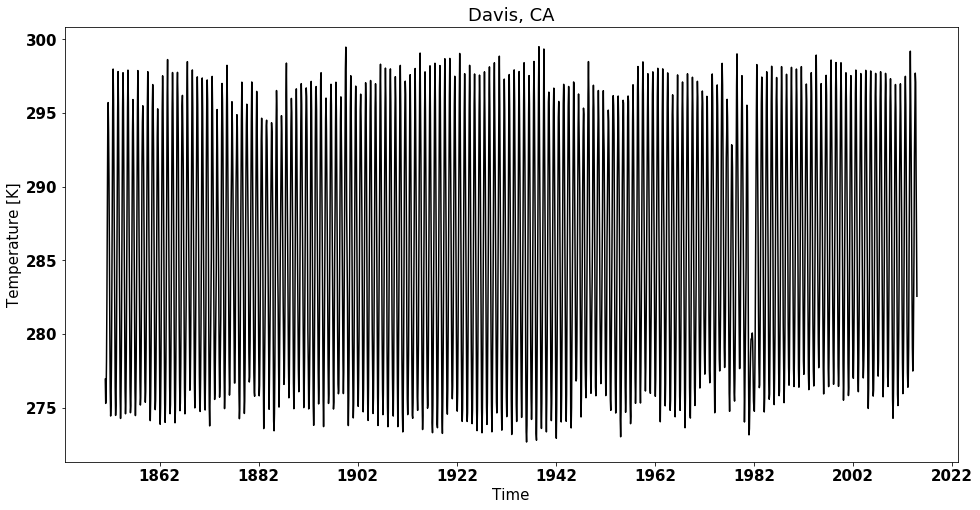

In [2]:
""" get the timeseries of temperature from Davis """
# set the reanalysis file na
infile = '../data/air.sfc.mon.mean.nc'

# open the netCDF file and read the temperature data
fin = nc.Dataset(infile,'r')

# load the temperature variable
temperature_var = fin.variables['air']

# get the temperature array (this notation is specific to netCDF)
temperature = temperature_var[:]

# get the latitude and longitude arrays
lat = fin.variables['lat'][:]
lon = fin.variables['lon'][:]

# set the lat/lon of Davis, as reported by google
davis_lat = 38.5449
davis_lon = 121.7405

# get the latitude index nearest to the Davis latitude
i_lat_davis = find_nearest(lat,davis_lat)

# get the longitude index nearest to the Davis latitude
j_lon_davis = find_nearest(lon, davis_lon)

# extract all temperatures for the lat/lon of Davis
davis_temperature = temperature[:,i_lat_davis,j_lon_davis]

""" plot the timeseries """

# pull time from the file
time_var = fin.variables['time']

# extract the time variable and convert it to fractional years (we've seen this before)
times = time_var[:]

# convert to datetime
dates = nc.num2date(times,time_var.units)

fig,ax = PP.subplots(figsize=(16,8))

ax.plot(dates,davis_temperature,'k-')

ax.set_xlabel('Time')
ax.set_ylabel('Temperature [K]')
ax.set_title('Davis, CA')

PP.show()

# Detrending
A common operation for doing Fourier analysis is to: remove the mean and detrend the data.  Numpy/scipy make these easy.

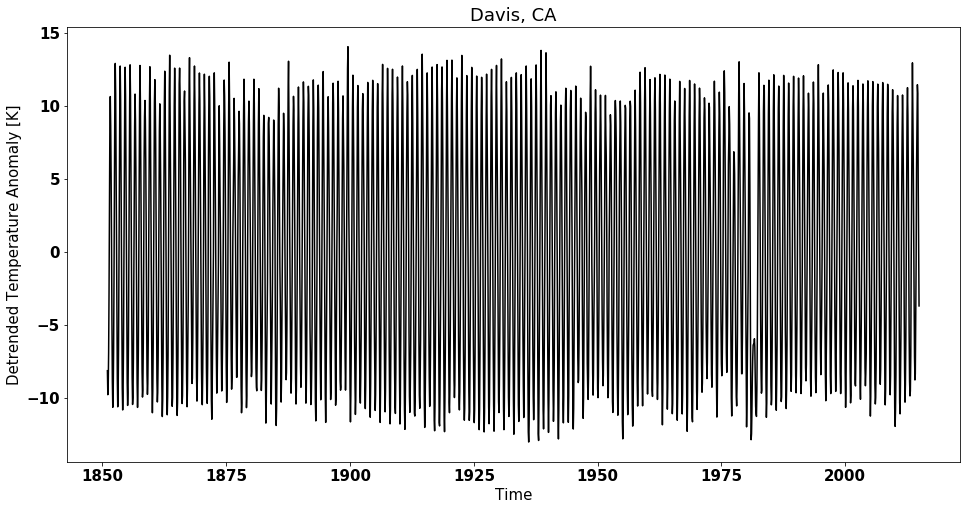

In [3]:
# convert dates to numeric units
days_since = nc.date2num(dates,'days since 1850-01-01 00:00:00')
# convert to years
years = days_since/365.25 + 1850

# remove the average of the timeseries
davis_temp_anom = davis_temperature - average(davis_temperature)

# calculate a temporal trend
slope,intercept,_,_,_ = scipy.stats.linregress(years,davis_temp_anom)

# evaluate the estimated line at all of the time points
davis_trend_line = slope*years + intercept

# subtract this trendline from the data (this 'detrends' it)
davis_temp_anom = davis_temp_anom - davis_trend_line

# plot again (should now be centered on 0 in the y direction)
fig,ax = PP.subplots(figsize=(16,8))

ax.plot(years,davis_temp_anom,'k-')

ax.set_xlabel('Time')
ax.set_ylabel('Detrended Temperature Anomaly [K]')
ax.set_title('Davis, CA')

PP.show()

# Spectrum (fourier) analysis

This section demonstrates how to use the fourier transform to look at the time series spectrum.

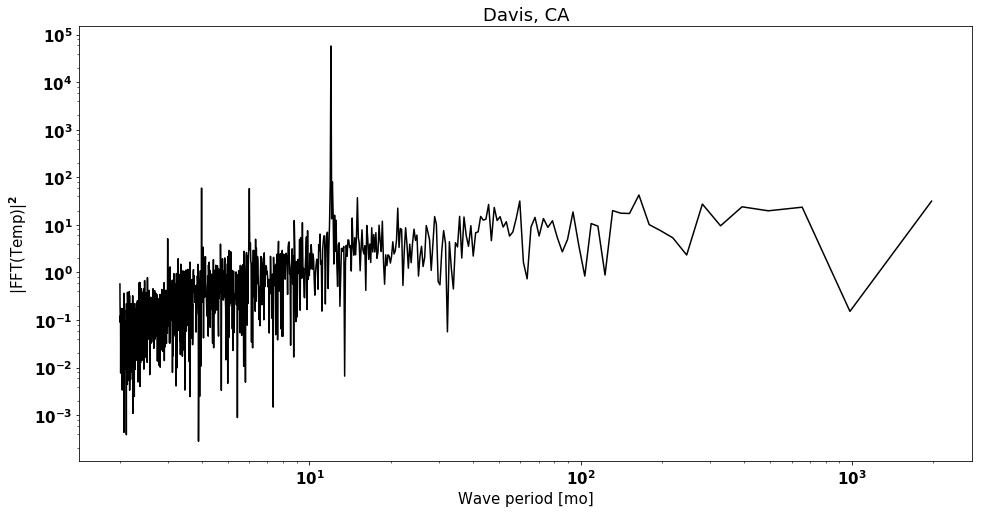

In [4]:
# calculate the FFT
davis_temp_fft = fft.rfft(davis_temp_anom)

# normalize the FFT (so that the sum of the FFT2 is the sum of the real signal squared)
davis_temp_fft = davis_temp_fft/sqrt(len(davis_temp_anom))

# get the frequencies at which the FFT is plotted
# set the grid spacing to be 1 month
freqs = fft.rfftfreq(len(davis_temp_anom), d = 1)

# calculate the period (omit the 0 frequency)
periods = 1./freqs[1:]

# convert frequency to period

# plot the power spectrum (omit the 0 frequency)
davis_temp_power_spectrum = abs(davis_temp_fft[1:])**2

fig,ax = PP.subplots(figsize=(16,8))

# use a log-log scale
ax.set_yscale('log')
ax.set_xscale('log')


ax.plot(periods,davis_temp_power_spectrum,'k-')

ax.set_xlabel('Wave period [mo]')
ax.set_ylabel('|FFT(Temp)|$^2$')
ax.set_title('Davis, CA')

PP.show()

We see one major peak in the spectrum just above a period of 10 months.  I hypothesize that this corresponds to the seasonal cycle (12 months).  If this hypothesis is correct, then a vertical line plotted at 12 months should go through the peak.

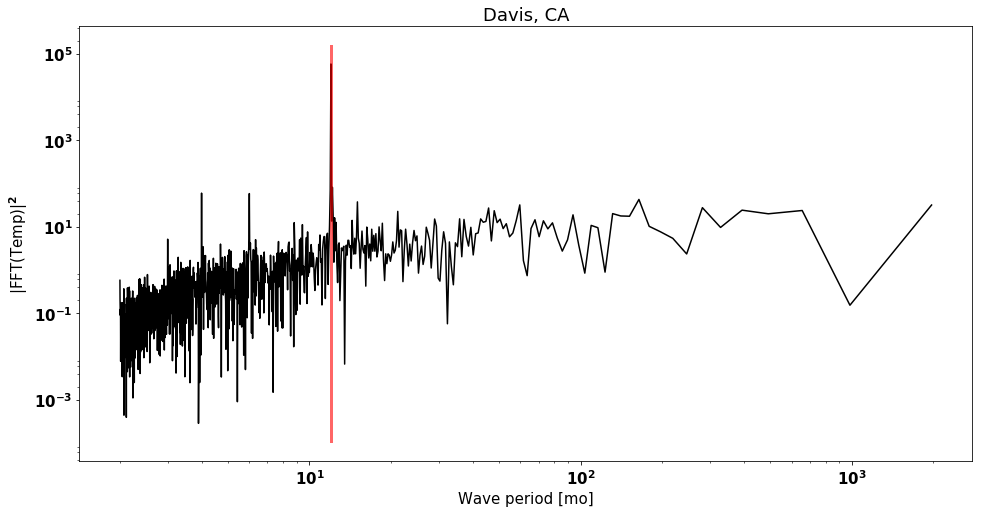

In [5]:
""" plot the spectrum again, with a 12-month line """

fig,ax = PP.subplots(figsize=(16,8))

# use a log-log scale
ax.set_yscale('log')
ax.set_xscale('log')


ax.plot(periods,davis_temp_power_spectrum,'k-')

ax.plot([12,12],ax.get_ylim(),'r-',linewidth=3,alpha=0.6)

ax.set_xlabel('Wave period [mo]')
ax.set_ylabel('|FFT(Temp)|$^2$')
ax.set_title('Davis, CA')

PP.show()

Further, I hypothesize that the other frequencies are harmonics of this: 6 months and 3 months.

Let's test:

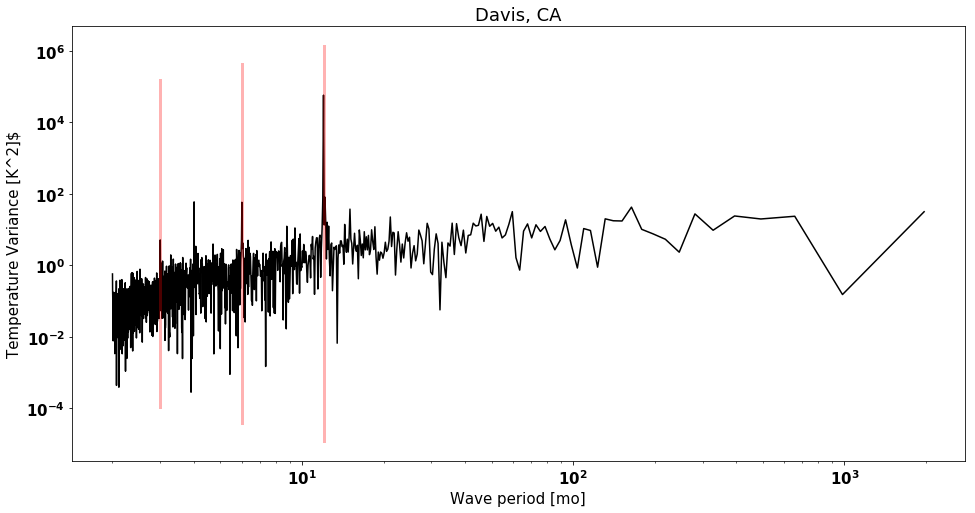

In [6]:
fig,ax = PP.subplots(figsize=(16,8))

# use a log-log scale
ax.set_yscale('log')
ax.set_xscale('log')


ax.plot(periods,davis_temp_power_spectrum,'k-')

for f in [3,6,12]:
    ax.plot([f,f],ax.get_ylim(),'r-',linewidth=3,alpha=0.3)

ax.set_xlabel('Wave period [mo]')
ax.set_ylabel('Temperature Variance [K^2]$')
ax.set_title('Davis, CA')

PP.show()

So I was right about two of them, but not the one at 4 months.  Interesting.  Any thoughts on what that might physically represent?

# Spectral filtering
Often we want to filter a signal to remove frequencies.  For example, in this timeseries, the annual cycle is so huge, it is difficult to see any trend.

Let's try applying a simple low-pass filter (lets the long periods through)



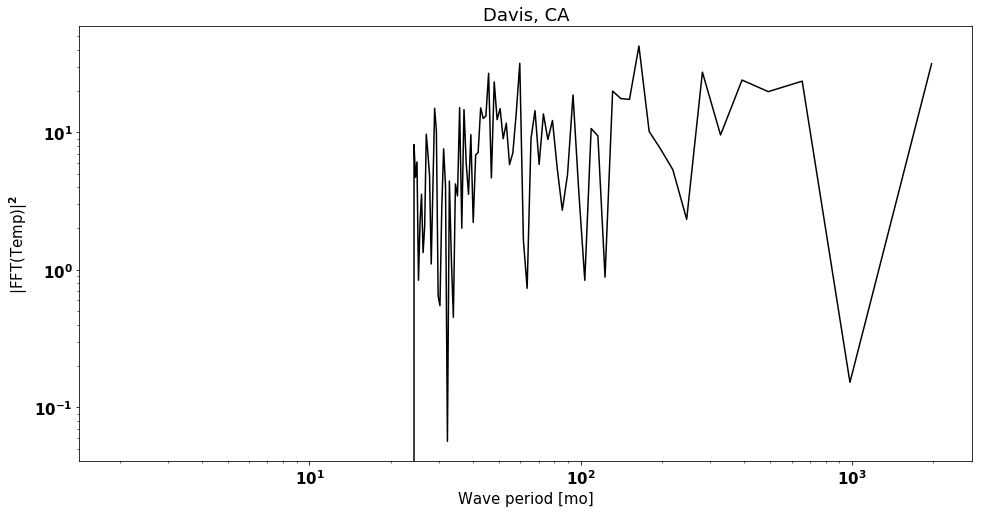

In [7]:
""" use a simple filter """

# get indices where the period is less than 24 months
i_less_24 = nonzero(periods < 24)[0] + 1 # account for the fact that periods doesn't include the 0 frequency)

# set the spectrum to 1 a those points
filtered_fft = array(davis_temp_fft)
filtered_fft[i_less_24] = 0

# recalculate and replot the spectrum
# plot the power spectrum (omit the 0 frequency)
filtered_spectrum = abs(filtered_fft[1:])**2

fig,ax = PP.subplots(figsize=(16,8))

# use a log-log scale
ax.set_yscale('log')
ax.set_xscale('log')


ax.plot(periods,filtered_spectrum,'k-')

ax.set_xlabel('Wave period [mo]')
ax.set_ylabel('|FFT(Temp)|$^2$')
ax.set_title('Davis, CA')

PP.show()

Now let's transform back to real space to see what the signal looks like.

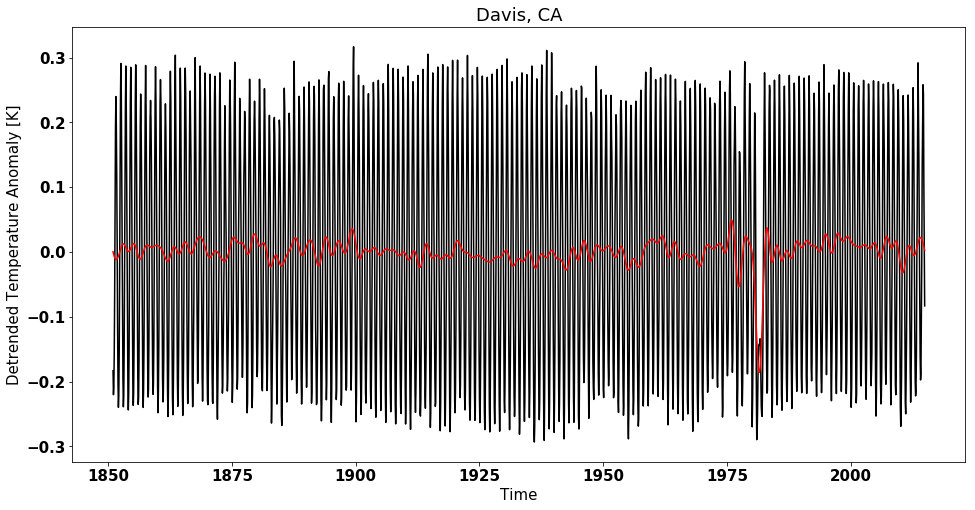

In [8]:
# calculate the filtered signal
filtered_signal = fft.irfft(filtered_fft,len(davis_temp_anom))
# calculate the original signal
orig_signal = fft.irfft(davis_temp_fft,len(davis_temp_anom))

# plot again (should now be centered on 0 in the y direction)
fig,ax = PP.subplots(figsize=(16,8))

ax.plot(years,orig_signal,'k-')
ax.plot(years,filtered_signal,'r-')

ax.set_xlabel('Time')
ax.set_ylabel('Detrended Temperature Anomaly [K]')
ax.set_title('Davis, CA')

PP.show()